# Predicting Car Prices
In this project we will be using the Automobile Data Set from the UCI Machine Learning Repository to create a predictive model for car prices.  We'll be using information about the technical aspects of the vehicle such as the motor's displacement, weight of the car, miles per gallon, how fast the car accelerates, and more.

We'll be using a simple but powerful Machine Learning algorithm.  This is the K-Nearest Neighbors algorithm.  Behind the scenes, this algorithm is not very complex.  It uses the full training data and when a prediction is to be made, it searches through the whole training set for the K most similar instances (the neighbors).  The value for K can change based on how many neighbors you want to group.  When using this algorithm for regression, based on the number of K instances, we'll find the mean output variable.  

Typically to determine which of the K instances we use, the algorithm will measure the distance between the input  and the actual datapoints with the Euclidean distance. Euclidean distance is calculated as the square root of the sum of the squared differences between a new point (x) and an existing point (xi) across all input attributes j.

KNN is a bit different than other Machine Learning algorithms, because it is doesn't actually learn.  It just utilizes the raw training instances to find similar datapoints to what was requested and takes the mean.

In this project, I will use KNN to run these predictions and utilize different error metrics to see how close our predictions are.  We will use several different types of training vs test data splits to show the differences in the outcomes based on how you handle the data.  Lastly, we will tweak the models hyperparameters by running grid searches to see the ideal number of neighbors and utilize feature selection.

## Reading in the Data
To begin our analysis, we'll start by reading in the data and do some quick cleaning to help get the dataset ready for the KNN algorithm.

Since the dataset file is <code>.data</code>, the column names will not match what is in the datasets documentation.  We'll have to account for this.

In [1]:
#import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cols = ['symboling','normalized_losses','make','fuel_type','aspiration','num_doors',
       'body_style','drive_wheels','engine_location','wheel_base','length','width',
       'height','curb_weight','engine_type','num_cylinders','engine_size','fuel_system',
       'bore','stroke','compression_ratio','horsepower','peak_rpm','city_mpg','highway_mpg',
       'price']
cars = pd.read_csv('imports-85.data', names = cols)
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized_losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel_type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num_doors          205 non-null    object 
 6   body_style         205 non-null    object 
 7   drive_wheels       205 non-null    object 
 8   engine_location    205 non-null    object 
 9   wheel_base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb_weight        205 non-null    int64  
 14  engine_type        205 non-null    object 
 15  num_cylinders      205 non-null    object 
 16  engine_size        205 non

In [3]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Given that our goal is to run the KNN algorithm on the data, we are only going to want to focus on continuous values (numeric) to use as the features and then chose the target column <code>price</code>.  We could use one hot encoding to create 1 and 0 values for the labels, but that's above the scope of this project.

In [4]:
continuous_vals = ['normalized_losses', 'wheel_base', 'length', 
                   'width', 'height', 'curb_weight', 'engine_size', 
                   'bore', 'stroke', 'compression_ratio', 'horsepower', 
                   'peak_rpm', 'city_mpg', 'highway_mpg','price']
numeric_cars = cars[continuous_vals]
numeric_cars.head()

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


Now that we have all the columns we're going to be interested in for our analysis, we need to fix a few inconsitencies and convert everyting to numeric.

Given that we'll be running a predictive model, we can not have missing values.  We can see right away that the <code>'normalized_losses'</code> column has values represented using a <code>'?'</code>.  We'll first need to replace those with <code>NaN</code> values. We'll also want to convert all columns to numeric since a lot of them are objects types.

In [5]:
numeric_cars = numeric_cars.replace('?',np.nan)
numeric_cars = numeric_cars.astype('float')
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized_losses  164 non-null    float64
 1   wheel_base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb_weight        205 non-null    float64
 6   engine_size        205 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression_ratio  205 non-null    float64
 10  horsepower         203 non-null    float64
 11  peak_rpm           203 non-null    float64
 12  city_mpg           205 non-null    float64
 13  highway_mpg        205 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 24.1 KB


We can see that all columns are now the numeric type <code>'float'</code>.  However, given that each column should have 205 non-null entries, we can see right off the bat there are some missing values here.  To understand a clearer picture about the amount missing per column, we can see the sums of null values.

In [6]:
numeric_cars.isnull().sum()

normalized_losses    41
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_size           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

It seems that the <code>normalized_losses</code> has the most missing values.  We could easily drop all of these columns, but since <code>normalized_losses</code> has a fair amount missing values, we can take the column means and fill them in.  However, we need to drop the <code>price</code> null value rows because since that is our target for predictions, it needs to be accurate.

In [7]:
numeric_cars = numeric_cars.dropna(subset = ['price'])
numeric_cars = numeric_cars.fillna(numeric_cars.mean())
numeric_cars.isnull().sum()

normalized_losses    0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_size          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

Now we have all the missing values taken care of, we need to normalize our data so each value is within a range of 0 to 1. This will help speed up and improve the accuracy of our model.  That way the range of all values is similar and not too far off from each other.  The only column we don't want to normalize is our target value <code>price</code>.

In [8]:
#save original price values to replace the new normalized price numbers 
price = numeric_cars['price']

numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price
numeric_cars.head()

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


Now that we have the data cleaned and normalized, we can begin running the KNN models.

## Univariate K-Nearest Neighbor
We'll first start with a univariate KNN model on each column to gain insight on which column performs the best.  We will begin by creating a simple function to split our data into a train/test set for validation.  Then the function will instantiate the KNN class, fit the model, and then make predictions on the test set.  Finally, we'll calculate a few different error metrics.  We'll be using MAE(mean absolute error) and RMSE(root mean squared error).

The mean abolute error will calculate the absolute difference between the prediction and the actual value and then average the values.  The root mean squared error, takes the square root of the mean squared error, which takes the difference between the prediction and the actual value, squares it, and then takes the mean of all the values.  When it comes to comparing the two error metrics, if we want to give more weight to points further away from the mean, ie. being off by 1000 is more than twice as bad as being off by 500 then RMSE is the preferred metric.  If the distance of being off isn't as critical, we could use MAE.

For this first model, we'll use a 50/50 train/test split.  Typically with a 50/50 split, this would be part of a holdout validation.  For example, you would shuffle and then split the dataset into two equal parts.  You would first train the model on the first set.  Then you would test the model on the next set.  You would then switch the two data sets and run the train/test and repeat.  Lastly, you would average the error metrics to see how it performed.  For this first example, we won't do the switch and repeat step yet.

There are a couple of ways to split the dataset.  We could manually do it by initiating a random seed with <code>numpy</code>, shuffling the index and resetting the dataframe with the new index.  We'd then split the dataset by the 50/50 split (or whatever split you want).  For example, this would look like:
    
<code>#initiate seed
    np.random.seed(1)</code>
    
   <code> #randomize order of rows
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)</code>
    
   <code> #divide number of rows in half
    last_train_row = int(len(rand_df) / 2)</code>
    
   <code> #split train/test 50/50>
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]</code>

However, part of the <code>sklearn</code> library, they have a function already built to split the dataset into the requested split and you can shuffle the data as well.  We'll be using that test/train split for simplicity purposes.  We also have the option to chose a <code>random_state</code> so the shuffle that is used can be replicated.

In [9]:
def knn_train_test(train_col,target_col,df):
    knn = KNeighborsRegressor()

    #sklearn train/test split
    X_train, X_test, y_train, y_test = train_test_split(df[[train_col]], df[[target_col]], 
                                                        test_size = 0.5, random_state = 100)
    
    #fit model
    knn.fit(X_train, y_train)
    
    #make predictions
    predicted_labels = knn.predict(X_test)
    
    #error metrics
    mae = mean_absolute_error(y_test['price'], predicted_labels)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
    return rmse,mae

rmse_results = {}
mae_results = {}

#train each column and return MAE and RMSE for each column
for col in numeric_cars.columns[:-1]:
    rmse_val,mae = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val
    mae_results[col] = mae
    
#create series to view results in a cleaner way   
rmse_results_series = pd.Series(rmse_results, name = 'RMSE').sort_values()
mae_results_series = pd.Series(mae_results, name = 'MAE').sort_values()
print(rmse_results_series)
print('-'*40)
print(mae_results_series)
print('-'*40)

horsepower           3284.967858
engine_size          3547.987263
city_mpg             3995.665789
curb_weight          4175.202639
highway_mpg          4350.183196
length               5412.087391
width                5626.063467
compression_ratio    5681.637952
wheel_base           6196.682680
bore                 7416.457038
stroke               7970.234827
normalized_losses    7985.678175
height               8314.297214
peak_rpm             8470.576298
Name: RMSE, dtype: float64
----------------------------------------
horsepower           2281.633663
curb_weight          2328.853465
engine_size          2442.459406
city_mpg             2610.835644
highway_mpg          2639.831683
width                3245.295050
length               3442.398020
wheel_base           3722.154455
compression_ratio    4066.582178
bore                 4604.239604
height               5056.053465
stroke               5341.667327
peak_rpm             5998.358416
normalized_losses    6111.530693
Name: MA

Looking at the KNN results for each column, it seems that <code>engine_size</code> and <code>horsepower</code> offer the lowest RMSE values.  However, for MAE, the two lowest are <code>horsepower</code> and <code>curb_weight</code> and the average amount the predictions are off is around $2,300.  Since we are trying to estimate a cars price, we want to give more weight to the values that are further off.  Given that, we should stick with RMSE. <code>engine_size</code> and <code>horsepower</code> may be good feature columns to work with for making more accurate predictions.

KNN by default chooses 5 neighbors to average the values to produce the prediction.  We can update our function to run the KNN model on multiple different neighbor values to see if we can find a better amount of neighbors.  We'll also update our train/test split to a more suitable 75/25 split.  We'll continue to use the <code>random_state</code> of 100, so we can make sure the shuffling stays the same for this function.

In [10]:
def knn_train_test(train_col,target_col,df):
    #sklearn train/test split
    X_train, X_test, y_train, y_test = train_test_split(df[[train_col]], df[[target_col]],
                                                        test_size = 0.25, random_state = 100)
    
    #fit model for different k values
    k_values = [1,3,5,7,9]
    k_rmses = {}
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)

        knn.fit(X_train, y_train)
    
        #make predictions
        predicted_labels = knn.predict(X_test)
    
        #error metrics
        rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

#train each column and return RMSE for each column
for col in numeric_cars.columns[:-1]:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

#create series to view results    
k_rmse_results_series = pd.DataFrame.from_dict(k_rmse_results)
k_rmse_results_series

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
1,7625.325353,4931.200908,5153.514025,4138.686047,8507.387640,5615.604128,4410.761846,9599.922662,7889.552599,7758.281330,2380.591185,7997.940008,4528.096445,5250.574297
3,6296.600595,5806.812220,5037.456000,4928.755086,8057.973556,5067.508984,3356.324739,7266.149699,7197.836496,6251.730466,2350.408402,8599.166330,4883.536132,4556.392635
5,6526.629285,6752.041273,5265.574220,5355.025402,8193.121100,4733.193902,3344.692117,7566.093158,7199.659760,6708.646539,2582.309034,8481.281159,4438.007749,4655.059329
7,7374.596525,7033.610601,5560.770281,5831.471157,8142.302462,4978.555905,3809.002014,7428.891383,7987.244111,6619.402237,2830.381115,8266.636368,4456.917834,4735.248752
9,8032.904932,7076.682090,5838.531485,6070.797922,8487.005041,4767.276343,3740.989704,6990.426908,8489.777949,6753.097206,3286.724003,8363.277221,4454.931011,4777.769784


Now that we trained the model for 1,3,5,7,and 9 different neighbors, there is a lot of data here.  It will help if we can visualize the differences here with a simple line plot.

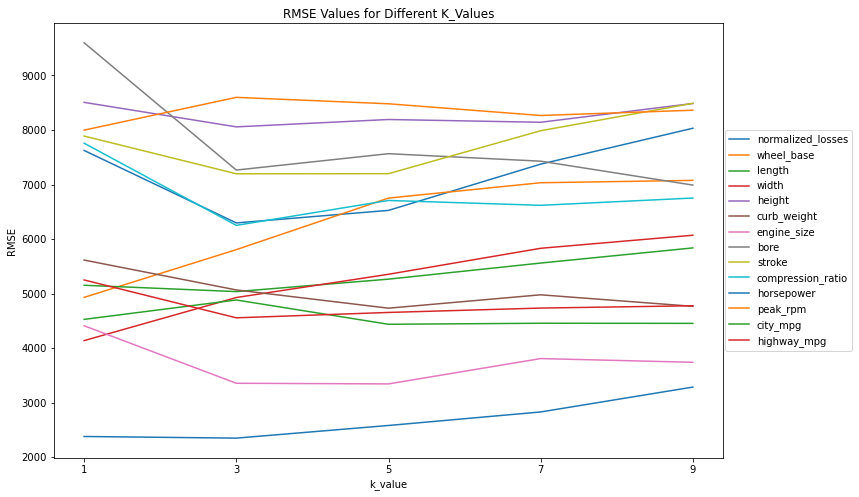

In [11]:
plt.figure(figsize=(12,8))
plt.plot(k_rmse_results_series)
plt.xlabel('k_value')
plt.xticks([1,3,5,7,9])
plt.ylabel('RMSE')
plt.legend(k_rmse_results_series.columns, loc = 'right', bbox_to_anchor=(1.2, .50))
plt.title('RMSE Values for Different K_Values')
plt.show()

Here we can see that both <code>horsepower</code> and <code>engine_size</code> still offer the lowest RMSE values and it seems that 3 neighbors seems to be the best amount before the error metric starts to increase.  The number of neighbors greatly affects the success of KNN.  Too little or too many neighbors, cause the predictions to become inaccurate.

## Multivariate KNN
Now that we have ran the KNN model on each column individually and have seen some best performing features, we should run the KNN model on multiple different columns together.  This should potentially help get more accurate results and reduce the bias vs variance trade off.

We'll update our function to combine the 2 best features through 6 best features and see what the new RMSE values will be.  We'll determine our best features by taking the average of all RMSE values for each column amongst each neighbor value.  We'll begin by running the new KNN model using the default neighbors of 5.

In [12]:
sorted_series_avg_rmse = k_rmse_results_series.mean().sort_values()
sorted_features = sorted_series_avg_rmse.index
sorted_series_avg_rmse

horsepower           2686.082748
engine_size          3732.354084
city_mpg             4552.297834
highway_mpg          4795.008959
curb_weight          5032.427852
width                5264.947123
length               5371.169202
wheel_base           6320.069419
compression_ratio    6818.231556
normalized_losses    7171.211338
stroke               7752.814183
bore                 7770.296762
height               8277.557960
peak_rpm             8341.660217
dtype: float64

In [13]:
def knn_train_test(train_cols,target_col,df):
    #sklearn train/test split
    X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[[target_col]], 
                                                        test_size = 0.25, random_state = 100)
    
    #fit model for different k values
    k_values = [5]
    k_rmses = {}
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)

        knn.fit(X_train, y_train)
    
        #make predictions
        predicted_labels = knn.predict(X_test)
    
        #error metrics
        rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for feature_group in range(2,7):
    k_rmse_results['{} best features {}: '.format(feature_group,sorted_features.values[:feature_group])
                  ] = knn_train_test(sorted_features[:feature_group],'price',numeric_cars)
k_rmse_results

{"2 best features ['horsepower' 'engine_size']: ": {5: 3288.49772472024},
 "3 best features ['horsepower' 'engine_size' 'city_mpg']: ": {5: 2980.0601794160425},
 "4 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg']: ": {5: 3070.8439376516294},
 "5 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight']: ": {5: 3743.7624551758504},
 "6 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight' 'width']: ": {5: 3989.482544459747}}

Here it seems that focusing on 3 best features yields the best RMSE results.  However, the RMSE is a bit higher than just using <code>horsepower</code> as an individual feature.  If we were to focus only on one feature, we would have to run different cross-validation techniques to make sure we are not potentially overfitting the data.

## Hyperparameter Tuning
Now that we have seen how the RMSE can change based on which columns we use and how many neighbors we use, it will be interesting to see how much the above feature selections change once we update the neighbors from 5.

We'll rewrite our function again to run the model for each feature selection groups from 1 all the way to 25 neighbors.

In [14]:
def knn_train_test(train_cols,target_col,df):
    #sklearn train/test split
    X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[[target_col]], 
                                                        test_size = 0.25, random_state = 100)
    
    #fit model for different k values
    k_values = [i for i in range(1,25)]
    k_rmses = {}
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)

        knn.fit(X_train, y_train)
    
        #make predictions
        predicted_labels = knn.predict(X_test)
    
        #error metrics
        rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for feature_group in range(2,7):
    k_rmse_results['{} best features {}: '.format(feature_group,sorted_features.values[:feature_group])
                  ] = knn_train_test(sorted_features[:feature_group],'price',numeric_cars)

k_rmse_results_df = pd.DataFrame.from_dict(k_rmse_results)
k_rmse_results_df

,2 best features ['horsepower' 'engine_size']:,3 best features ['horsepower' 'engine_size' 'city_mpg']:,4 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg']:,5 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight']:,6 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight' 'width']:
1,3023.131045,2828.656838,2758.246815,2210.527548,2538.887405
2,3325.727139,3056.380667,2961.398593,2668.050897,3119.718525
3,3143.814693,2857.967971,2987.147762,2764.768226,3465.020395
4,2972.608157,2807.166495,2581.966974,3301.574758,3976.848778
5,3288.497725,2980.060179,3070.843938,3743.762455,3989.482544
6,3439.414372,3132.675089,3413.835324,3872.670065,4307.497663
7,3540.914928,3463.455971,3564.755129,3986.590789,4468.969634
8,3836.781885,3768.803061,3662.118313,4207.085853,4632.342296
9,4111.213140,3873.991725,3756.575661,4360.597280,4621.550082
10,4174.752076,3963.582808,3846.414831,4498.847699,4739.763133


Again, we're left with a lot of data to try to sift through.  We'll visualize the data again to paint a clearer picture.

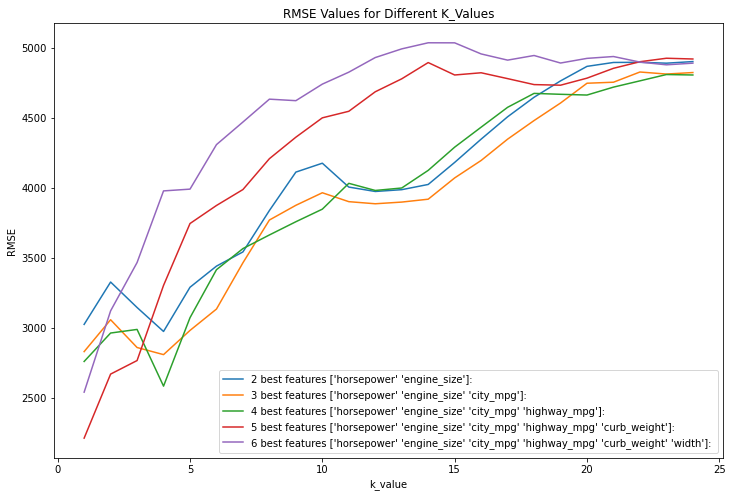

In [15]:
plt.figure(figsize=(12,8))
plt.plot(k_rmse_results_df)
plt.xlabel('k_value')
plt.ylabel('RMSE')
plt.legend(k_rmse_results_df.columns, loc = 'lower right')
plt.title('RMSE Values for Different K_Values')
plt.show()

Looking at this line plot, we can see that again, the more neighbors we use, the worse the model becomes.  What's interesting is that every single group of features performs better with just 1 neighbor.  For example, 5 best features, with just 1 neighbor yields a 2,210 RMSE.  A possibile explanation could be that this particular model works well with just 1 neighbor.  However, it also could mean that we are experiencing overfitting of the data.  A way to test this would be to change up our cross-validation techniques to see if the results yield any difference.

If the 1 neighbor is a result of overfitting and we disregard the 1 neighbor results, it seems that 4 best features with 4 neighbors offers the lowest RMSE value.

An interesting test would be to run the exact same model as above, but chose a different <code>random_state</code> to receive a different shuffle.

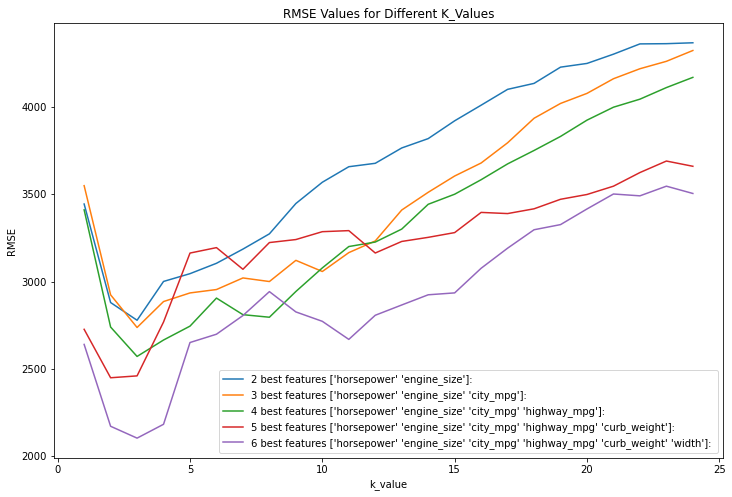

In [16]:
def knn_train_test(train_cols,target_col,df):
    #sklearn train/test split
    X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[[target_col]], 
                                                        test_size = 0.25, random_state = 1)
    
    #fit model for different k values
    k_values = [i for i in range(1,25)]
    k_rmses = {}
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)

        knn.fit(X_train, y_train)
    
        #make predictions
        predicted_labels = knn.predict(X_test)
    
        #error metrics
        rmse = np.sqrt(mean_squared_error(y_test, predicted_labels))
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for feature_group in range(2,7):
    k_rmse_results['{} best features {}: '.format(feature_group,sorted_features.values[:feature_group])
                  ] = knn_train_test(sorted_features[:feature_group],'price',numeric_cars)

k_rmse_results_df = pd.DataFrame.from_dict(k_rmse_results)
k_rmse_results_df

plt.figure(figsize=(12,8))
plt.plot(k_rmse_results_df)
plt.xlabel('k_value')
plt.ylabel('RMSE')
plt.legend(k_rmse_results_df.columns, loc = 'lower right')
plt.title('RMSE Values for Different K_Values')
plt.show()

Here we can see that each group performed worse with just 1 neighbor and that the new best group was 6 best features at 3 neighbors.

From this we can determine that how we split and shuffle our data is very important in creating an accurate model.  We'll experiment with this one step further and run the same groups of best features, but now with a KFold cross-validation.

What KFold cross-validation does is splits the data into an amount of folds that you specify.  For example, if we want 10 folds, the data will be split evenly into 10 partitions and the model will run 10 times.  Each time, using 1 partition as the test set and the rest as the training set.  This repeats until each partition was used as the test set.

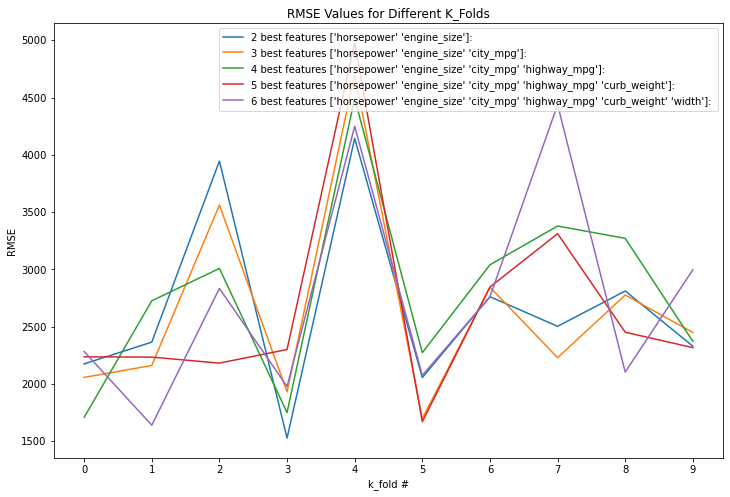

,2 best features ['horsepower' 'engine_size']:,3 best features ['horsepower' 'engine_size' 'city_mpg']:,4 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg']:,5 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight']:,6 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight' 'width']:
0,2175.742655,2057.877897,1709.348261,2237.236130,2284.256627
1,2365.612371,2162.059136,2726.037090,2234.882660,1640.600373
2,3945.798484,3562.306347,3008.982328,2182.504964,2834.448968
3,1527.814519,1932.872034,1750.998198,2301.067662,1978.649795
4,4143.646112,4706.454734,4494.227917,4978.222979,4249.949845
5,2056.475280,1698.276803,2273.628155,1670.834078,2075.882541
6,2762.453406,2845.611089,3040.890362,2846.391839,2761.123733
7,2503.469091,2229.736877,3378.879501,3311.814988,4437.868659
8,2811.942619,2776.832713,3271.297126,2452.110764,2104.558624
9,2330.026353,2450.185172,2372.454306,2317.350507,2997.258791


In [17]:
def knn_train_test(train_cols,target_col,df):
    #fit model with KFold set to 10
    knn = KNeighborsRegressor(n_neighbors = 3)
    kf = KFold(10, shuffle=True, random_state = 1)

    rmses = cross_val_score(knn, df[train_cols], df[target_col],scoring="neg_root_mean_squared_error", cv=kf)
    return np.abs(rmses)

rmse_results = {}

for feature_group in range(2,7):
    rmse_results['{} best features {}: '.format(feature_group,sorted_features.values[:feature_group])
                ] = knn_train_test(sorted_features[:feature_group],'price',numeric_cars)
rmse_results_series = pd.DataFrame.from_dict(rmse_results)


plt.figure(figsize=(12,8))
plt.plot(rmse_results_series)
plt.xlabel('k_fold #')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel('RMSE')
plt.legend(rmse_results_series.columns, loc = 'upper right')
plt.title('RMSE Values for Different K_Folds')
plt.show()
rmse_results_series

Here we can see that among each fold, the RMSE changes quite a bit for each feature group.  Let's take the means for each group to see what the final RMSE values would look like.

In [18]:
rmse_results_series.mean().sort_values()

3 best features ['horsepower' 'engine_size' 'city_mpg']:                                         2642.221280
5 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight']:             2653.241657
2 best features ['horsepower' 'engine_size']:                                                    2662.298089
6 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg' 'curb_weight' 'width']:     2736.459795
4 best features ['horsepower' 'engine_size' 'city_mpg' 'highway_mpg']:                           2802.674324
dtype: float64

Here we can see that running a 10 fold cross-validation and taking the mean of the results, our best performing model is 3 of the best features with a RMSE of 2,642.

One last interesting visualization would be to actually see some of the predictions compared to the original price.  We'll create one more function to help accomplish this.

In [19]:
def knn_train_test(train_cols,target_col,df):
    knn = KNeighborsRegressor()

    #sklearn train/test split
    X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[[target_col]], 
                                                        test_size = 0.25, random_state = 1)
    
    #fit model
    knn.fit(X_train, y_train)
    
    #make predictions
    predicted_labels = knn.predict(X_test)
    y_test['predicted_price'] = predicted_labels

    return y_test

pred_vs_true = knn_train_test(['engine_size','horsepower','city_mpg'],'price',numeric_cars)
pred_vs_true.sample(10)

,price,predicted_price
96,7499.0,6382.8
170,11199.0,14271.4
179,15998.0,15739.2
101,13499.0,16454.4
70,31600.0,25529.2
59,8845.0,9233.2
169,9989.0,14271.4
203,22470.0,14614.8
97,7999.0,6382.8
36,7295.0,6929.8


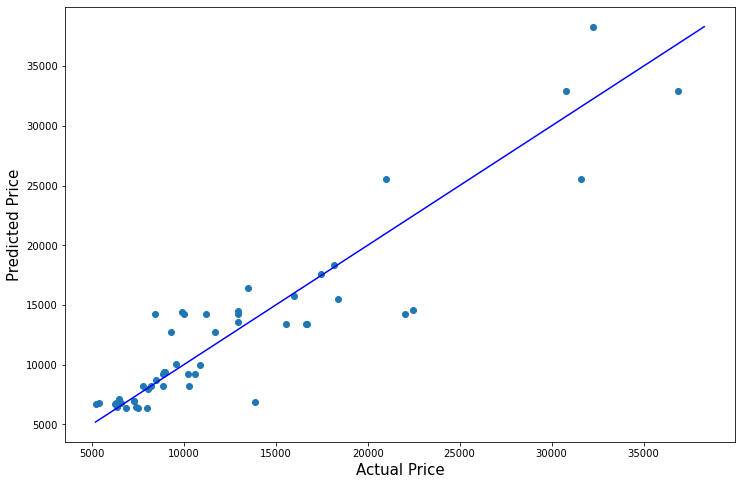

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(pred_vs_true['price'],pred_vs_true['predicted_price'])
p1 = max(max(pred_vs_true['predicted_price']), max(pred_vs_true['price']))
p2 = min(min(pred_vs_true['predicted_price']), min(pred_vs_true['price']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Price', fontsize=15)
plt.ylabel('Predicted Price', fontsize=15)
plt.show()

In [21]:
difference = mean_absolute_error(pred_vs_true['price'],pred_vs_true['predicted_price'])
difference

2045.7098039215687

As we can see from the scatter plot, the predictions were not too far off and the average amount the prediction was off was by $2,045.  As the price of the car increased, the less accurate the predictions became.  We also did not have a lot of examples where the price of the car was more expensive.

# Conclusion
During this project we were able to run different versions of the KNN algorithm using many different hyperparamters, cross-validation techniques, and utilizing feature selection.

Using this very simple model, we were able to produce relatively accurate predictions on car prices.  Using a more complex model may yield better results, but if we're more interested in ballparking the price of a car based on specifc features, ie. Horsepower, using KNN can yield quick and accurate results.  

Ultimately, the next step would be to gather significantly more data and re-run our models to see how the predictions fair once we have an ample amount of data.